## 1. aplikasi yang membantu perusahaan untuk memprediksi harga saham.

### a. 

load the data

In [3]:
import pandas as pd

# Load the data
amzn_data = pd.read_csv('AMZN.csv')

# Display the first few rows of the data
amzn_data.head()
amzn_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5.758000e+03
mean,340.458153,344.156408,336.344390,340.417580,340.417580,7.556094e+06
std,523.365374,528.138556,517.726971,523.140207,523.140207,7.325904e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.460001,38.334999,36.812499,37.562500,37.562500,3.685525e+06
50%,81.965000,83.520000,79.875000,81.599998,81.599998,5.692450e+06
75%,335.267494,337.537491,331.727501,334.290001,334.290001,8.594350e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,1.043292e+08


eskplorasi dan visualisasi data

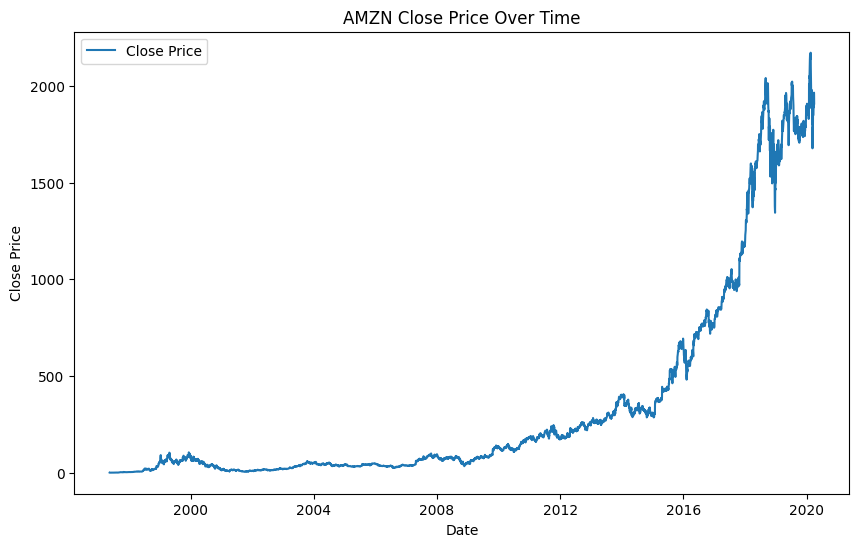

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
amzn_data = pd.read_csv('AMZN.csv')

# Convert the Date column to datetime
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])

# Sort data by date
amzn_data = amzn_data.sort_values('Date')

# Use only Date and Close columns
amzn_data = amzn_data[['Date', 'Close']]

# Plot the data to understand the trend
plt.figure(figsize=(10, 6))
plt.plot(amzn_data['Date'], amzn_data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AMZN Close Price Over Time')
plt.legend()
plt.show()

Harga saham AMZN mengalami kenaikan yang signifikan dari sekitar tahun 2010 hingga 2020, dengan beberapa fluktuasi di sepanjang waktu. Kenaikan ini mencerminkan pertumbuhan bisnis Amazon yang pesat selama periode tersebut.

In [8]:
pip install ace

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


praproses data

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
amzn_data['Close'] = scaler.fit_transform(amzn_data['Close'].values.reshape(-1,1))

# Function to create a dataset with window size and horizon
def create_dataset(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

# Creating the dataset
window_size = 5
horizon = 1
X, y = create_dataset(amzn_data['Close'].values, window_size, horizon)

# Splitting the dataset into train, validation, and test sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Display shapes of the datasets
(X_train.shape, X_val.shape, X_test.shape), (y_train.shape, y_val.shape, y_test.shape)


(((4602, 5), (575, 5), (576, 5)), ((4602,), (575,), (576,)))

- train set : 4602, 5 -> 5 adalah window size yang digunakan, artinya setiap sampel terdiri dari 5 data point historis yang digunakan sebagai input. 4602 adalah jumlah target (harga saham pada horizon yang ditentukan) yang sesuai dengan jumlah sampel input pada train set.
- validation set : 575, 5 -> 576 adalah jumlah sampel dalam test set.
5 adalah window size. 575 adalah jumlah target yang sesuai dengan jumlah sampel input pada validation set.
- test set : 576, 5 -> 576 adalah jumlah sampel dalam test set.
5 adalah window size. 576 adalah jumlah target yang sesuai dengan jumlah sampel input pada test set.

build dan train model LTSM

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape input data to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0012 - val_loss: 1.4094e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0030e-06 - val_loss: 1.1572e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.9386e-06 - val_loss: 1.3646e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.0455e-06 - val_loss: 9.9318e-05
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.3651e-06 - val_loss: 9.1278e-05
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0083e-05 - val_loss: 9.3217e-05
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.7133e-06 - val_loss: 9.7047e-05
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7106e-06 - val_loss: 8.6256e-05
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.2995e-06 - val_loss: 8.6941e-05
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7121e-06 - val_loss: 1.0262e-04
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - 

buat prediksi dan visualisasi hasil

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


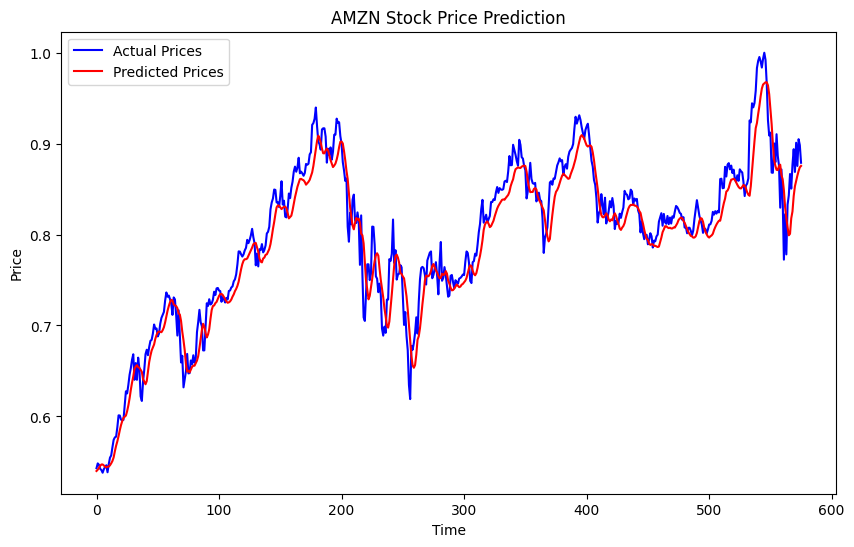

In [13]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()

Grafik tersebut menunjukkan prediksi harga saham Amazon (AMZN) yang dibuat oleh model LSTM dibandingkan dengan harga aktualnya. Garis biru merepresentasikan harga saham aktual, sementara garis merah merepresentasikan harga saham yang diprediksi. Model LSTM mampu mengikuti pola harga saham dengan cukup baik, menunjukkan bahwa prediksi yang dihasilkan memiliki akurasi yang tinggi.

## b.

build model LTSM baseline 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the baseline LSTM model
baseline_model = Sequential()
baseline_model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
baseline_model.add(LSTM(units=50, activation='relu'))
baseline_model.add(Dense(1))

# Compile the model
baseline_model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape input data to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


train model LTSM baseline

In [15]:
# Train the model
baseline_history = baseline_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1241e-06 - val_loss: 6.1626e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.8759e-06 - val_loss: 5.5841e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.7267e-06 - val_loss: 5.0383e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.0132e-06 - val_loss: 9.5380e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.5034e-06 - val_loss: 4.5024e-04
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.8292e-06 - val_loss: 9.0896e-04
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.9261e-06 - val_loss: 0.0011
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.9939e-06 - val_loss: 6.7467e-04
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.2127e-06 - val_loss: 8.6437e-04
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss:

evaluasi dan visualiasi hasil

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1131e-04
Baseline Test Loss: 0.0009279397781938314
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


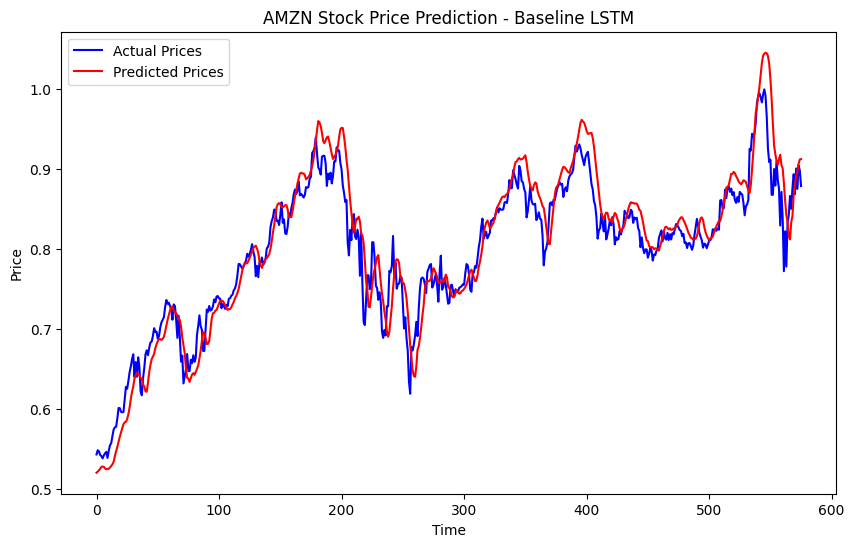

In [16]:
# Evaluate the model on the test data
baseline_test_loss = baseline_model.evaluate(X_test, y_test)
print(f"Baseline Test Loss: {baseline_test_loss}")

# Make predictions
baseline_predictions = baseline_model.predict(X_test)
baseline_predictions = scaler.inverse_transform(baseline_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Prices')
plt.plot(baseline_predictions, color='red', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('AMZN Stock Price Prediction - Baseline LSTM')
plt.legend()
plt.show()

Grafik ini menunjukkan prediksi harga saham Amazon (AMZN) oleh model LSTM baseline dibandingkan dengan harga aktual. Garis biru adalah harga aktual, dan garis merah adalah prediksi. Model baseline LSTM dapat mengikuti tren harga saham dengan baik, namun terdapat beberapa perbedaan di puncak dan lembah, menunjukkan area untuk perbaikan lebih lanjut.

## c.

alasan saya menggunakan menggunakan pendekatan yang saya pilih
saya melakukan beberapa modifikasi dalam arsitektur nya
- Menambahkan satu lapisan LSTM tambahan.
- Mengubah fungsi aktivasi menjadi tanh pada LSTM.
- Menambahkan layer Dropout untuk regularisasi.
- Menggunakan callback EarlyStopping untuk menghentikan pelatihan ketika model berhenti memperbaiki performa pada validation set.

modifikasi arsitektur model LTSM

In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the modified LSTM model
modified_model = Sequential()
modified_model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)))
modified_model.add(Dropout(0.2))
modified_model.add(LSTM(units=100, activation='tanh'))
modified_model.add(Dropout(0.2))
modified_model.add(Dense(1))

# Compile the model
modified_model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape input data to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Train the model with early stopping
modified_history = modified_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 7.8540e-04 - val_loss: 1.2199e-04
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.1697e-05 - val_loss: 1.0825e-04
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.5458e-05 - val_loss: 9.8200e-04
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.1603e-05 - val_loss: 8.2773e-04
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.7715e-05 - val_loss: 9.8536e-05
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.6075e-05 - val_loss: 9.5297e-05
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.3438e-05 - val_loss: 9.2983e-05
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.1744e-05 - val_loss: 8.4959e-05
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6987e-05 - val_loss: 1.7907e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.5545e-05 - val_loss: 8.1784e-05
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss

evaluasi dan visualisasi hasil

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4708e-04
Modified Model Test Loss: 0.000518111337441951
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


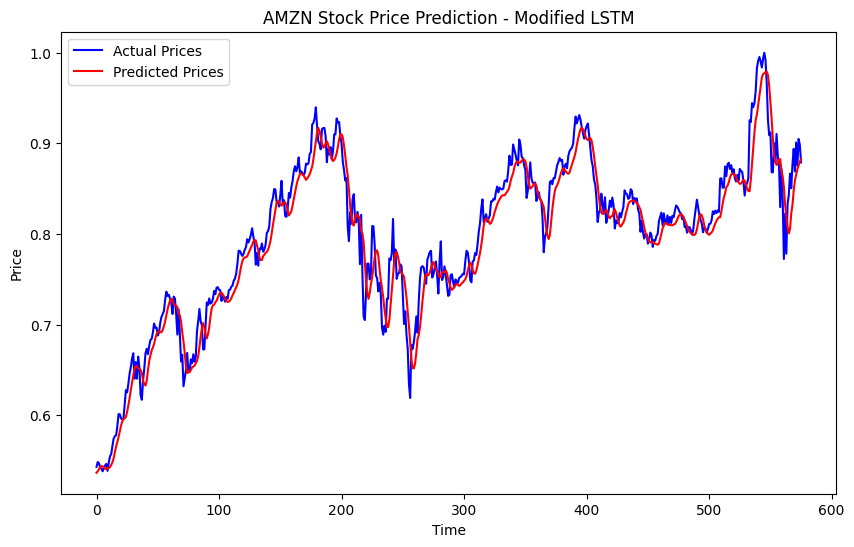

In [18]:
# Evaluate the model on the test data
modified_test_loss = modified_model.evaluate(X_test, y_test)
print(f"Modified Model Test Loss: {modified_test_loss}")

# Make predictions
modified_predictions = modified_model.predict(X_test)
modified_predictions = scaler.inverse_transform(modified_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Prices')
plt.plot(modified_predictions, color='red', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('AMZN Stock Price Prediction - Modified LSTM')
plt.legend()
plt.show()


penjelasan approximation nya:
1. Menambahkan Layer LSTM dan Dropout: Penambahan lapisan LSTM dengan unit yang lebih banyak dan layer dropout bertujuan untuk meningkatkan kapasitas model dan mengurangi overfitting.
2. Mengubah Fungsi Aktivasi menjadi tanh: Fungsi tanh sering digunakan dalam LSTM karena dapat memetakan input ke nilai antara -1 dan 1, yang membantu dalam menjaga stabilitas gradien selama pelatihan.
3. Early Stopping: Menggunakan early stopping untuk menghentikan pelatihan ketika performa pada validation set tidak lagi membaik, sehingga dapat menghindari overfitting dan menghemat waktu pelatihan.

### d.

import lobrary evaluasi

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fungsi untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


evaluasi model baseline

In [20]:
# Evaluate the baseline model on the test data
baseline_predictions = baseline_model.predict(X_test)
baseline_predictions = scaler.inverse_transform(baseline_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics for baseline model
baseline_rmse = np.sqrt(mean_squared_error(y_test_scaled, baseline_predictions))
baseline_mae = mean_absolute_error(y_test_scaled, baseline_predictions)
baseline_mape = mean_absolute_percentage_error(y_test_scaled, baseline_predictions)

print(f"Baseline Model RMSE: {baseline_rmse}")
print(f"Baseline Model MAE: {baseline_mae}")
print(f"Baseline Model MAPE: {baseline_mape}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Baseline Model RMSE: 0.030462106591438994
Baseline Model MAE: 0.023030355164941875
Baseline Model MAPE: 2.9373668379848246


evaluasi model modified

In [22]:
# Evaluate the modified model on the test data
modified_predictions = modified_model.predict(X_test)
modified_predictions = scaler.inverse_transform(modified_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics for modified model
modified_rmse = np.sqrt(mean_squared_error(y_test_scaled, modified_predictions))
modified_mae = mean_absolute_error(y_test_scaled, modified_predictions)
modified_mape = mean_absolute_percentage_error(y_test_scaled, modified_predictions)

print(f"Modified Model RMSE: {modified_rmse}")
print(f"Modified Model MAE: {modified_mae}")
print(f"Modified Model MAPE: {modified_mape}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Modified Model RMSE: 0.022762059758318635
Modified Model MAE: 0.01749307801146434
Modified Model MAPE: 2.2103750203698285


## penjelasan hasil nya
- RMSE (Root Mean Squared Error): RMSE mengukur akar rata-rata dari kuadrat kesalahan. Nilai ini memberikan indikasi seberapa besar prediksi berbeda dari nilai sebenarnya dalam skala yang sama dengan data aslinya.
- MAE (Mean Absolute Error): MAE mengukur rata-rata absolut dari kesalahan. Nilai ini menunjukkan seberapa besar rata-rata kesalahan prediksi tanpa memperhitungkan arah kesalahan.
- MAPE (Mean Absolute Percentage Error): MAPE mengukur rata-rata absolut dari kesalahan dalam bentuk persentase. Ini memberikan gambaran seberapa besar kesalahan prediksi relatif terhadap nilai sebenarnya.

## interpretasi hasil nya
### model baseline :
- RMSE: Memberikan nilai kesalahan yang dapat dibandingkan dengan skala harga saham.
- MAE: Menunjukkan kesalahan rata-rata dalam unit harga saham.
- MAPE: Menunjukkan kesalahan rata-rata dalam bentuk persentase dari nilai sebenarnya.

### model modified 
- RMSE: Jika lebih rendah dibandingkan baseline, menunjukkan bahwa model yang dimodifikasi lebih baik dalam menangkap pola dari data.
- MAE: Jika lebih rendah dibandingkan baseline, menunjukkan bahwa model yang dimodifikasi memiliki kesalahan rata-rata yang lebih kecil.
- MAPE: Jika lebih rendah dibandingkan baseline, menunjukkan bahwa model yang dimodifikasi lebih akurat dalam hal persentase kesalahan.